In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 22.3 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing image...

image 1/1 /content/test_image_full3.jpg: 640x480 1 Expiry-date, 148.8ms
Speed: 3.8ms preprocess, 148.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

Extracted Text:
--------------------------------------------------
Region 1 (Bounding Box: (318, 638, 880, 1085)):
Text Lines:
  Balch No; (Confidence: 0.20)
  0415176 (Confidence: 0.97)
  Mig: Dale (Confidence: 0.29)
  12/2024 (Confidence: 0.73)
  Expiry Dale (Confidence: 0.49)
  11/2026 (Confidence: 1.00)
  Maxmum (Confidence: 0.62)
  Relail Pnce (Confidence: 0.85)
  602 . 25 (Confidence: 0.55)
  (Inclusive of (Confidence: 0.80)
  Al Taxes) (Confidence: 0.64)
--------------------------------------------------


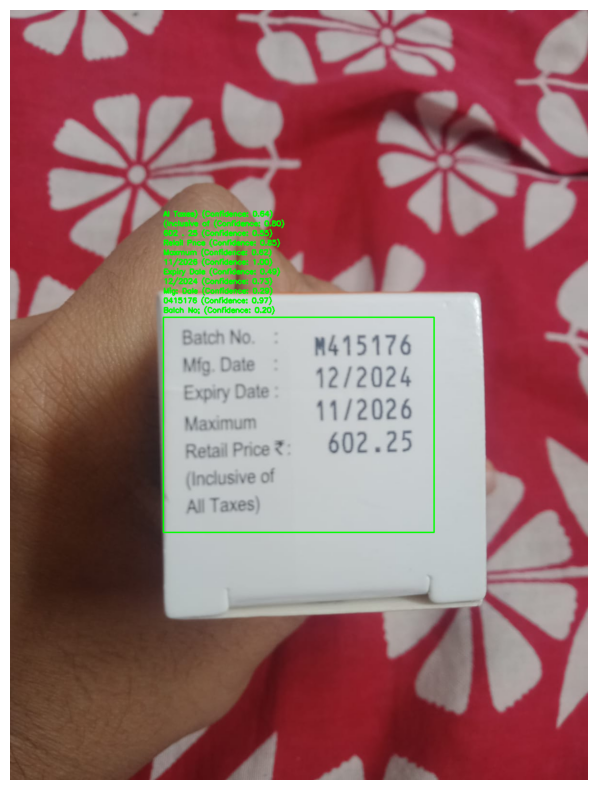

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
from ultralytics import YOLO

class MedicineTextReader:
    def __init__(self):
        """Initialize with EasyOCR for text detection."""
        self.reader = easyocr.Reader(['en'])  # Initialize EasyOCR for English text detection

    def extract_text_from_region(self, cropped_image):
        """Use EasyOCR to extract text from a given image region."""
        # Get the text from the cropped region using EasyOCR
        result = self.reader.readtext(cropped_image)

        extracted_text = []
        for detection in result:
            # Extract the detected text and confidence
            text = detection[1]
            confidence = detection[2]
            extracted_text.append({'text': text, 'confidence': confidence})

        return extracted_text

    def process_image(self, image_path, yolo_model):
        """Process the image and extract text from YOLO-detected regions using EasyOCR."""
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")

        # Get YOLO detections
        results = yolo_model(image_path)

        extracted_text = []  # List to store text from detected blocks

        # Iterate through the detected regions
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            scores = result.boxes.conf.cpu().numpy()

            for i, (box, score) in enumerate(zip(boxes, scores)):
                if score < 0.5:  # Only consider boxes with a confidence above 0.5
                    continue

                # Get the coordinates of the bounding box
                x1, y1, x2, y2 = map(int, box)
                padding = int(min(x2-x1, y2-y1) * 0.1)

                # Crop the region with padding
                x1_pad = max(0, x1 - padding)
                y1_pad = max(0, y1 - padding)
                x2_pad = min(image.shape[1], x2 + padding)
                y2_pad = min(image.shape[0], y2 + padding)

                cropped = image[y1_pad:y2_pad, x1_pad:x2_pad]

                if cropped.size == 0:
                    continue

                # Use EasyOCR to extract text from the cropped image
                region_text = self.extract_text_from_region(cropped)
                if region_text:
                    extracted_text.append({
                        'bbox': (x1, y1, x2, y2),
                        'text': region_text
                    })

        # Return both the image and extracted text for further use
        return image, extracted_text

def visualize_results(image, extracted_text):
    """Visualize the detected text regions on the image."""
    output = image.copy()

    for region in extracted_text:
        x1, y1, x2, y2 = region['bbox']

        # Draw bounding box
        cv2.rectangle(output, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw text lines inside or near the bounding box
        text_y = y1 - 10
        for i, line in enumerate(region['text']):
            text_info = f"{line['text']} (Confidence: {line['confidence']:.2f})"
            cv2.putText(output,
                       text_info,
                       (x1, text_y - i*20),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       0.5,
                       (0, 255, 0),
                       2)

    return output

def main():
    from google.colab import drive
    drive.mount('/content/drive')

    model_path = '/content/best.pt'  # YOLO model path
    image_path = '/content/test_image_full3.jpg'  # Input image path

    yolo_model = YOLO(model_path)  # Load YOLO model
    reader = MedicineTextReader()

    print("Processing image...")
    image, extracted_text = reader.process_image(image_path, yolo_model)

    print("\nExtracted Text:")
    print("-" * 50)
    for i, region in enumerate(extracted_text):
        print(f"Region {i+1} (Bounding Box: {region['bbox']}):")
        print("Text Lines:")
        for line in region['text']:
            print(f"  {line['text']} (Confidence: {line['confidence']:.2f})")
        print("-" * 50)

    # Visualize the image with bounding boxes
    output_image = visualize_results(image, extracted_text)
    output_path = '/content/drive/MyDrive/medicine_text_output.jpg'
    cv2.imwrite(output_path, output_image)

    # Display the output image in Colab
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


In [5]:
!pip install google-generativeai


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
from ultralytics import YOLO
import google.generativeai as genai
import os


image 1/1 /content/medicine_test_image.jpg: 640x544 1 Expiry-date, 160.3ms
Speed: 6.2ms preprocess, 160.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


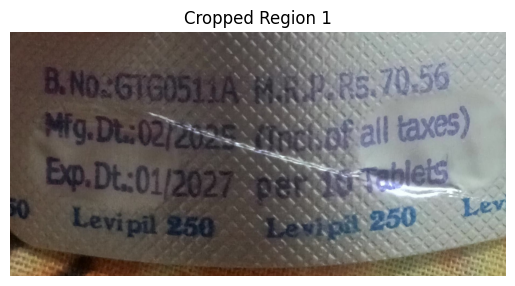

In [33]:
# Load YOLO model
model_path = '/content/best.pt'  # Update as needed
image_path = '/content/medicine_test_image.jpg'  # Your test image
yolo_model = YOLO(model_path)

# Read image and run detection
image = cv2.imread(image_path)
results = yolo_model(image_path)

boxes = results[0].boxes.xyxy.cpu().numpy()
scores = results[0].boxes.conf.cpu().numpy()

# Store cropped images
cropped_images = []
coordinates = []

for box, score in zip(boxes, scores):
    if score < 0.75:
        continue
    x1, y1, x2, y2 = map(int, box)
    padding = int(min(x2 - x1, y2 - y1) * 0.1)
    x1, y1 = max(0, x1 - padding), max(0, y1 - padding)
    x2, y2 = min(image.shape[1], x2 + padding), min(image.shape[0], y2 + padding)

    cropped = image[y1:y2, x1:x2]
    if cropped.size > 0:
        cropped_images.append(cropped)
        coordinates.append((x1, y1, x2, y2))

# Visualize detected regions
for i, crop in enumerate(cropped_images):
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title(f"Cropped Region {i+1}")
    plt.axis('off')
    plt.show()


In [34]:
reader = easyocr.Reader(['en'], gpu=False)
ocr_texts = []

for i, cropped in enumerate(cropped_images):
    results = reader.readtext(cropped)
    texts = [text for (_, text, _) in results]
    ocr_texts.append({
        'bbox': coordinates[i],
        'text': texts
    })

# Display OCR results
print("Extracted Text from Detected Regions:")
print("=" * 60)
for i, region in enumerate(ocr_texts):
    print(f"Region {i+1} (Bounding Box: {region['bbox']}):")
    for line in region['text']:
        print(f"  {line}")
    print("-" * 60)


Extracted Text from Detected Regions:
Region 1 (Bounding Box: (47, 1483, 1880, 2385)):
  8 No.GvG0511A
  Nit
  Rs, 70.56
  Mfg Dt:02/2125
  all taxes)
  Bp Dt:01/2027`
  08r
  M
  Lev
  250
  Levtal
  Ynof
  Tablets
  250
  Levi
  Pil
------------------------------------------------------------


In [9]:

import getpass
api_key = getpass.getpass("Enter your Gemini API Key: ")
genai.configure(api_key=api_key)


Enter your Gemini API Key: ··········


In [37]:
# Prepare the Gemini input
full_text = " ".join([line for region in ocr_texts for line in region['text']])

prompt = f"""
You are a helpful assistant. Given the following OCR text from a medicine strip or label:

\"\"\"{full_text}\"\"\"

Extract:
- Manufacturing Date (MFG Date)(excluding day,include month and year)
- Expiry Date(excluding day,include month and year)
- Number of Tablets(can't be between 5 to 10,usually more equal to 10,if less than 10 adjust to 10 and so on)

If anything is missing, you may estimate it based on standard medical expiry conventions (usually 2 years from manufacturing).
Just respond in a clean readable format, no need for JSON.
"""

model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt)

print("\nFinal Extracted Information (Predicted by Gemini):")
print("=" * 50)
print(response.text.strip())
print("=" * 50)



Final Extracted Information (Predicted by Gemini):
Manufacturing Date: 02/2025
Expiry Date: 01/2027
Number of Tablets: 10


What Problem we can face if we use TrOCR


In [23]:
!pip install transformers
!pip install torch torchvision


In [24]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Load TrOCR model (you can also try 'microsoft/trocr-base-handwritten')
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

def recognize_text_trocr(image_array):
    image = Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text.strip()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [28]:
# Load TrOCR model (printed or handwritten version)
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



image 1/1 /content/test_image_full3.jpg: 640x480 1 Expiry-date, 185.7ms
Speed: 5.2ms preprocess, 185.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


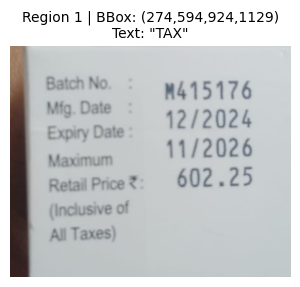


Summary of TrOCR Outputs:
Region 1 (BBox: (274, 594, 924, 1129)):
→ TAX
------------------------------------------------------------


In [32]:
import matplotlib.pyplot as plt

# Load test image
image_path = '/content/test_image_full3.jpg'
image = cv2.imread(image_path)
results = yolo_model(image_path)

boxes = results[0].boxes.xyxy.cpu().numpy()
scores = results[0].boxes.conf.cpu().numpy()

cropped_images, coordinates, trocr_outputs = [], [], []

# Process YOLO detections and run TrOCR
for i, (box, score) in enumerate(zip(boxes, scores)):
    if score < 0.75:
        continue

    x1, y1, x2, y2 = map(int, box)
    padding = int(min(x2 - x1, y2 - y1) * 0.1)
    x1, y1 = max(0, x1 - padding), max(0, y1 - padding)
    x2, y2 = min(image.shape[1], x2 + padding), min(image.shape[0], y2 + padding)

    cropped = image[y1:y2, x1:x2]
    if cropped.size == 0:
        continue

    cropped_images.append(cropped)
    coordinates.append((x1, y1, x2, y2))

    # Run TrOCR
    pil_img = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    pixel_values = processor(images=pil_img, return_tensors="pt").pixel_values
    generated_ids = trocr_model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    trocr_outputs.append({
        'bbox': (x1, y1, x2, y2),
        'text': text
    })

    # Show the cropped region with the predicted text
    plt.figure(figsize=(5, 3))
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Region {i+1} | BBox: ({x1},{y1},{x2},{y2})\nText: "{text}"', fontsize=10)
    plt.show()

# Print final list of texts
print("\nSummary of TrOCR Outputs:")
print("="*60)
for i, region in enumerate(trocr_outputs):
    print(f"Region {i+1} (BBox: {region['bbox']}):")
    print(f"→ {region['text']}")
    print("-" * 60)
